In [1]:
#Set google drive
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
#Install miniconda and rdkit
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2019-12-31 11:54:47--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71785000 (68M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  68.46M   127MB/s    in 0.5s    

2019-12-31 11:54:48 (127 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [71785000/71785000]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.2.0=py37_0
    - ca-certificates==2019.10.16=0
    - certifi==2019.9.11=py37_0
    - cffi==1.13.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_

In [3]:
#Read smiles files
with open('/content/gdrive/My Drive/Colab Notebooks/smiles.txt') as f:
  smiles = f.readlines()[:5000]
  smiles = [s.strip() for s in smiles]
  smiles = [s.split()[1] for s in smiles]
print (len(smiles))
print (smiles[:10])

5000
['O=[N+]([O-])c1ccc(O)c(/C=N/c2ccc3nccnc3c2)c1', 'CCOC(=O)C1CCCNC1=O', 'C/C(=N/O)C1=CC(C)(C)CCC1', 'Cc1cc(N/N=C/c2cccc([N+](=O)[O-])c2)nc(-n2nc(C)cc2C)n1', 'CCOc1ccc(C2NC(=O)NC(C)=C2C(=O)OCc2ccccc2)cc1', 'CC(/C=C/c1ccc2c3c(cccc13)CC2)=C\\C(=O)[O-].[Na+]', 'CC1(C)Cc2ccccc2/C(=C/C(=O)Nc2ccccc2[N+](=O)[O-])N1', 'Cc1cc(C)c(NC(=O)/C=C2\\NC(C)(C)Cc3ccccc32)c(C)c1.Cl', 'Cn1c(=O)c(C(=O)Nc2ccncc2)c(O)c2ccccc21', 'Cc1cc(O)nc(N2CCCCC2)n1']


In [4]:
#Calculate Morgan fingerprints and LogP of each molecule
from rdkit import Chem
from rdkit.Chem.Crippen import MolLogP
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np
import torch

X, Y = [], []
for s in smiles:
  m = Chem.MolFromSmiles(s)
  fp = np.array(AllChem.GetMorganFingerprintAsBitVect(m,2, nBits=1024))
  logp = MolLogP(m)
  X.append(fp)
  Y.append(logp)
  
#Convert to torch tensor
X = torch.from_numpy(np.array(X)).float()
Y = torch.from_numpy(np.array(Y)).float()

print (X.size())
print (Y.size())

torch.Size([5000, 1024])
torch.Size([5000])


In [5]:
#Divide training and test data
num_train = 4000
X_train = X[:num_train]
Y_train = Y[:num_train]
X_test = X[num_train:]
Y_test = Y[num_train:]

print (f'Num train data: {len(X_train)}')
print (f'Num test data: {len(X_test)}')


Num train data: 4000
Num test data: 1000


In [0]:
import torch
import torch.nn as nn

class LinearRegressor(torch.nn.Module):
  def __init__(self, D_in, D_out):
    super(LinearRegressor, self).__init__()
    self.linear = torch.nn.Linear(D_in, D_out)

  def forward(self, x):
    retval = self.linear(x)
    return retval

In [10]:
#Train model
import time
lr = 1e-4
model = LinearRegressor(1024,1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
loss_list = []
st = time.time()

X_train = X_train.cuda()
Y_train = Y_train.cuda()
X_test = X_test.cuda()
Y_test = Y_test.cuda()
model = model.cuda()

for i in range(5001):
  pred = model(X_train)
  pred = pred.squeeze(-1)
  loss = loss_fn(pred, Y_train)
  loss.backward()
  optimizer.step()
  loss_list.append(loss.data.cpu().numpy())
  if i%1000==0:
    print (i, loss.data.cpu().numpy())
end = time.time()
print ('Time:', end-st)

0 11.700397
1000 5.3600903
2000 2.5452783
3000 1.8143783
4000 1.7740214
5000 1.9062985
Time: 3.512173652648926


Text(0, 0.5, 'Loss')

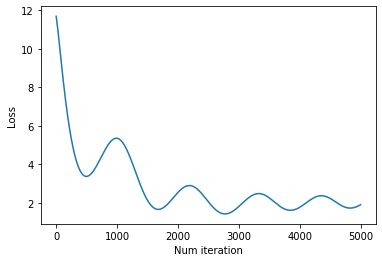

In [11]:
import matplotlib.pyplot as plt

plt.plot(loss_list)
plt.xlabel('Num iteration')
plt.ylabel('Loss')


In [12]:
#Test model
y_pred_train = model(X_train).squeeze(-1)
y_pred_test = model(X_test).squeeze(-1)

loss_train = loss_fn(Y_train, y_pred_train)
loss_test = loss_fn(Y_test, y_pred_test)

print ('Train loss:', loss_train.data.cpu().numpy())
print ('Test loss:', loss_test.data.cpu().numpy())

Train loss: 1.9081025
Test loss: 2.266856


Text(0, 0.5, 'Pred')

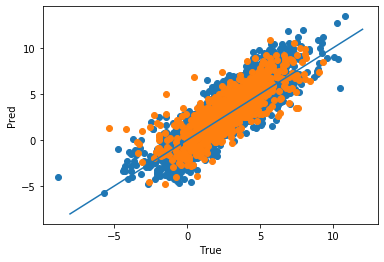

In [14]:

plt.scatter(Y_train.data.cpu().numpy(), y_pred_train.data.cpu().numpy())
plt.scatter(Y_test.data.cpu().numpy(), y_pred_test.data.cpu().numpy())
plt.plot([-8,12], [-8,12])
plt.xlabel('True')
plt.ylabel('Pred')
